Práctica 3: Regresión logística multi-clase.
===
Autores: Lidia Concepción Echeverría y Francisco Ponce Belmonte
---
En esta práctica aplicaremos la regresión logística multi-clase a un problema de clasificación de imágenes de números escritos a mano.

In [1]:
%matplotlib notebook
import csv
from scipy.io import loadmat
import numpy as np
import scipy.optimize as opt
from pandas.io.parsers import read_csv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from sklearn.preprocessing import PolynomialFeatures

Carga y muestra de datos.

In [2]:
data = loadmat('ex3data1.mat')
y = data['y']
x = data['X']
unos = np.full((5000,1),1)
th =np.zeros((401,1))
num_etiquetas = [1,2,3,4,5,6,7,8,9,10]
x = np.append(unos, x, axis=1)

<IPython.core.display.Javascript object>


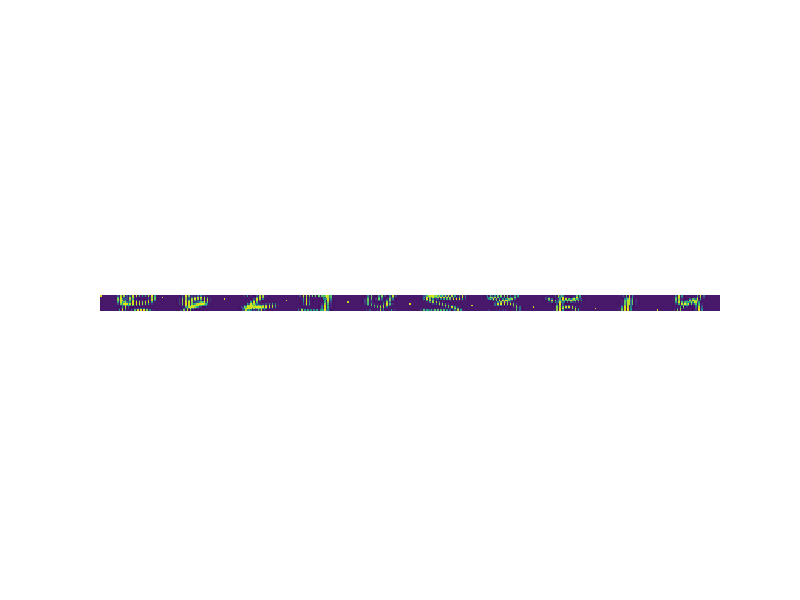

(-0.5, 400.5, 9.5, -0.5)

In [9]:
sample = np.random.choice(x.shape[0], 10)
plt.imshow(x[sample, :].reshape(-1,10).T)
plt.axis('off')

Vectorización de la regresión logística.
---
Funciones sigmoide y de coste (vectorizada), junto con su valor con theta inicializada a 0.

In [10]:
def sigmoide(z):
    s = np.dot(z,-1)
    e = np.exp(s)
    d = 1 + e
    return 1/d

In [11]:
def coste(th, x, y, lamda=1):
    g = sigmoide(np.dot(x,th))
    log1 = np.log(g)
    log2 = np.log(1-g)
    tr1 = np.dot(np.transpose(log1),y)
    tr2 = np.dot(np.transpose(log2),(1-y))
    c = -(tr1+tr2)/len(y)
    s = np.sum(th**2)/(2*len(y))
    return c + lamda*s
coste(th,x,y)

array([[160.39425758]])

Función vectorizada del gradiente con el término de regularización.

In [14]:
def lrgradientReg(theta,X,y, reg):
    m = y.size
    h = sigmoide(X.dot(theta.reshape(-1,1)))
      
    grad = (1/m)*X.T.dot(h-y) + (reg/m)*np.r_[[[0]],theta[1:].reshape(-1,1)]
        
    return(grad.flatten())

Clasificación de uno frente a todos.
---
Entrena un clasificador por cada una de las etiquetas, utilizando la función minimize.fmin_tnc. De esta forma, se consigue una matriz de pesos, que contienen el peso correspondiente a cada atributo para cada etiqueta posible. Tras el entrenamiento, se procede a realizar la predicción de los valores, multiplicando la matriz de pesos con los casos de X y tomando el máximo valor de cada caso. Esta matriz de resultados es lo que devuelve la función.

In [16]:
def oneVsAll(X, y, num_etiquetas, reg):
    matriz = []
    calificacion = np.zeros((num_etiquetas,X.shape[0]))
    th = np.zeros((x.shape[1],1))
    for i in range(num_etiquetas):
        c = np.isin(y,i+1)
        result = opt.fmin_tnc(func=coste, x0=th, fprime=lrgradientReg, args=(X, c*1,reg))
        th_opt = result[0]
        matriz.append(th_opt)
        
    j = np.dot(matriz,np.transpose(X))
    for u in range(len(X)):
        calificacion[np.argmax(j[:,u])][u] = 1
    return np.transpose(calificacion)

f =oneVsAll(x, y, 10, 0.1)

Función que cuenta los aciertos de la predicción generada en la clasificación uno frente a todos y su porcentaje.
Al tener varios casos posibles y múltiples clasificadores, el resultado de las predicciones resulta más acertado que los vistos en prácticas anteriores. 

In [18]:
def testeo(y, f):
    acertados = 0
    for i in range(len(y)):
        if np.argmax(f[i])+1 == y[i]:
            acertados +=1
    return acertados, acertados/len(y)*100
testeo(y,f)

(4823, 96.46000000000001)

Redes Neuronales
===
Utilizando una red neuronal con los datos ya dados, podremos comprobar su efectividad sobre este problema.

Carga de pesos y función de propagación hacia delante (para 1 capa).

In [19]:
weights = loadmat('ex3weights.mat')
theta1, theta2 = weights['Theta1'], weights['Theta2']

In [20]:
def propagacion (x,th):
    a = []
    unos = np.full((5000,1),1)
    for i in range(len(x)):
        z = np.dot(x[i],np.transpose(th))
        a.append(sigmoide(z))
    return np.append(unos,a, axis = 1)

Finalmente ejecutamos la función propagación 2 veces (1 por cada capa) y comprobamos de nuevo el resultado, viendo que este método resulta aún más efectivo que el clasificador oneVsAll.

In [21]:
f = propagacion(x,theta1)
f2 = propagacion(f,theta2)
f = np.copy(f2[:,1:])
testeo(y,f)

(4876, 97.52)